In [48]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

In [49]:
data_train = pd.read_csv('./train.csv')

In [50]:
data_testA = pd.read_csv('./testA.csv')

In [51]:
numerical_fea = data_train.select_dtypes(exclude='object').columns
categorical_fea = data_train.select_dtypes(include='object').columns

In [52]:
#remove target value y
label = 'isDefault'
numerical_fea = list(numerical_fea)
numerical_fea.remove(label)

In [53]:
'isDefault' in numerical_fea

False

# 1. Fill Null data

In [54]:
#check total null
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n2.1                

In [55]:
#Fill null numerical number with median 
#And fill null categorical number with mode since it represents common value
data_train[numerical_fea] = data_train[numerical_fea].fillna(data_train[numerical_fea].median())
data_train[categorical_fea] = data_train[categorical_fea].fillna(data_train[categorical_fea].mode())

In [56]:
#Apply the same steps on test data, which is necessary to keep train and test data same feature.
data_testA[numerical_fea] = data_testA[numerical_fea].fillna(data_testA[numerical_fea].median())
data_testA[categorical_fea] = data_testA[categorical_fea].fillna(data_testA[categorical_fea].mode())

In [57]:
#Run again to see if there is any nan left. As we see here that employment length is not changed yet.
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           0
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  0
regionCode                0
dti                       0
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies        0
revolBal                  0
revolUtil                 0
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     0
policyCode                0
n0                        0
n1                        0
n2                        0
n2.1                

# 2. Adjust datetime data type

In [58]:
#2.1 [EmploymentLength] is in categorical feature, and we can map it to number.
data_train.employmentLength

0           2 years
1           5 years
2           8 years
3         10+ years
4               NaN
            ...    
799995      7 years
799996    10+ years
799997    10+ years
799998    10+ years
799999      5 years
Name: employmentLength, Length: 800000, dtype: object

In [59]:
#Check the total types in employmentLength.
data_train.employmentLength.value_counts(dropna=False).sort_index()

1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
NaN           46799
Name: employmentLength, dtype: int64

In [60]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [61]:
for data in [data_train, data_testA]:
    data['employmentLength'].replace('10+ years', '10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 year', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [62]:
data_train['employmentLength'].value_counts(dropna=False)

10.0    262753
2.0      72358
0.0      64237
3.0      64152
1.0      52489
5.0      50102
4.0      47985
NaN      46799
6.0      37254
8.0      36192
7.0      35407
9.0      30272
Name: employmentLength, dtype: int64

In [63]:
#2.2 Split year and month as individual column from [earliesCreditLine]
data_train['earliesCreditLine'].value_counts()

Aug-2001    5567
Sep-2003    5403
Aug-2002    5403
Oct-2001    5258
Aug-2000    5246
            ... 
Feb-1960       1
Oct-1954       1
Oct-1957       1
Sep-1953       1
Aug-1955       1
Name: earliesCreditLine, Length: 720, dtype: int64

In [64]:
year_month = pd.to_datetime(data_train['earliesCreditLine'],format='%b-%Y')

In [65]:
year_month

0        2001-08-01
1        2002-05-01
2        2006-05-01
3        1999-05-01
4        1977-08-01
            ...    
799995   2011-08-01
799996   1989-05-01
799997   2002-07-01
799998   1994-01-01
799999   2002-02-01
Name: earliesCreditLine, Length: 800000, dtype: datetime64[ns]

In [66]:
data_train['earliesCreditLineYear'] = year_month.apply(lambda x: x.strftime('%Y'))

In [67]:
data_train['earliesCreditLineYear'].head(5)

0    2001
1    2002
2    2006
3    1999
4    1977
Name: earliesCreditLineYear, dtype: object

In [68]:
data_train['earliesCreditLineMonth'] = year_month.apply(lambda x: x.strftime('%m'))

In [69]:
data_train['earliesCreditLineMonth'].head(5)

0    08
1    05
2    05
3    05
4    08
Name: earliesCreditLineMonth, dtype: object

In [70]:
#2.3 Convert ['issueDate'] from datetime to days_count.
data_train['issueDate'].head(5)

0    2014-07-01
1    2012-08-01
2    2015-10-01
3    2015-08-01
4    2016-03-01
Name: issueDate, dtype: object

In [71]:
data_testA['issueDate'].min()

'2007-07-01'

In [72]:
min_time = data_train['issueDate'].min()

In [73]:
for data in [data_train, data_testA]:
    data['issueDate'] = pd.to_datetime(data['issueDate'], format='%Y-%m-%d')
    startdate = dt.datetime.strptime(min_time, '%Y-%m-%d')
    data['issueDateDay'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

# Comparing mapping and LabelEncoder when labeling ordinal variables

In [42]:
#2.4 Labeling ordinal variable ['grade'] by mapping
#for data in [data_train, data_testA]:
    #data['grade'] = data['grade'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})

In [79]:
#data_train['grade'].head(5)
#output will be
#0    5
#1    4
#2    4
#3    1
#4    3
#Name: grade, dtype: int64
#LabelEncoder assign labels from 0 to number of class-1, whereas mapping can start from 1. 

In [76]:
#2.5 Labeling ordinal variable ['grade'] by label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(['A','B','C','D','E','F','G'])
data_train['transgrade'] = le.transform(data_train['grade'])

In [82]:
data_train['grade'].head(5)

0    E
1    D
2    D
3    A
4    C
Name: grade, dtype: object

In [81]:
data_train['transgrade'].head(5)

0    4
1    3
2    3
3    0
4    2
Name: transgrade, dtype: int64

In [83]:
le.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G'], dtype='<U1')

In [78]:
data_train['transgrade'].value_counts()

1    233690
2    227118
0    139661
3    119453
4     55661
5     19053
6      5364
Name: transgrade, dtype: int64

In [46]:
#2.5 Labeling nominal variable by using get_dummies or One-hot encoding
data_train['verificationStatus'].value_counts()

1    309810
2    248968
0    241222
Name: verificationStatus, dtype: int64

In [47]:
pd.get_dummies(data_train['verificationStatus'])
#get_dummies()该列有多少种可能值就用多少列表示，一列代表一种可能值，与独热编码相似.由于特征维度会有所增加，所以此方法不适合高维。

,0,1,2
0,0,0,1
1,0,0,1
2,0,0,1
3,0,1,0
4,0,0,1
...,...,...,...
799995,1,0,0
799996,0,0,1
799997,0,0,1
799998,0,0,1


In [84]:
for data in [data_train, data_testA]:
    data = pd.get_dummies(data, columns=['subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'], drop_first=True)

# 3. Process extreme value by using 3Sigama and box plot

In [88]:
#3.1 Remove Outliers Using Normal Distribution and S.D.
#The approach is to remove the outlier points by eliminating any points that were above (Mean + 3*SD)
#and any points below (Mean - 3*SD).
#95% of values locate within 2SD, and 99.7% of values stay within 3SD.
def outlier_3sigama(data, fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    cut_off = 3 * data_std
    lower = data_mean - cut_off
    upper = data_mean + cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x: 'outlier' if x > upper or x < lower else 'normal')
    return data

In [87]:
data_train = data_train.copy()
data_train

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n9,n10,n11,n12,n13,n14,earliesCreditLineYear,earliesCreditLineMonth,issueDateDay,transgrade
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2.0,2,...,2.0,7.0,0.0,0.0,0.0,2.0,2001,08,2587,4
1,1,18000.0,5,18.49,461.90,D,D2,219843.0,5.0,0,...,5.0,13.0,0.0,0.0,0.0,2.0,2002,05,1888,3
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8.0,0,...,3.0,11.0,0.0,0.0,0.0,4.0,2006,05,3044,3
3,3,11000.0,3,7.26,340.96,A,A4,46854.0,10.0,1,...,6.0,9.0,0.0,0.0,0.0,1.0,1999,05,2983,0
4,4,3000.0,3,12.99,101.07,C,C2,54.0,NaN,1,...,7.0,12.0,0.0,0.0,0.0,4.0,1977,08,3196,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,799995,25000.0,3,14.49,860.41,C,C4,2659.0,7.0,1,...,10.0,14.0,0.0,0.0,0.0,3.0,2011,08,3318,2
799996,799996,17000.0,3,7.90,531.94,A,A4,29205.0,10.0,0,...,2.0,7.0,0.0,0.0,0.0,0.0,1989,05,2131,0
799997,799997,6000.0,3,13.33,203.12,C,C3,2582.0,10.0,1,...,4.0,5.0,0.0,0.0,1.0,4.0,2002,07,3044,2
799998,799998,19200.0,3,6.92,592.14,A,A4,151.0,10.0,0,...,8.0,16.0,0.0,0.0,0.0,5.0,1994,01,2802,0


In [89]:
for fea in numerical_fea:
    data_train = outlier_3sigama(data_train,fea)
    print(data_train[fea+'_outliers'].value_counts())
    print(data_train.groupby(fea+'_outliers')['isDefault'].sum())
    print('*'*10)

normal    800000
Name: id_outliers, dtype: int64
id_outliers
normal    159610
Name: isDefault, dtype: int64
**********
normal    800000
Name: loanAmnt_outliers, dtype: int64
loanAmnt_outliers
normal    159610
Name: isDefault, dtype: int64
**********
normal    800000
Name: term_outliers, dtype: int64
term_outliers
normal    159610
Name: isDefault, dtype: int64
**********
normal     794259
outlier      5741
Name: interestRate_outliers, dtype: int64
interestRate_outliers
normal     156694
outlier      2916
Name: isDefault, dtype: int64
**********
normal     792046
outlier      7954
Name: installment_outliers, dtype: int64
installment_outliers
normal     157458
outlier      2152
Name: isDefault, dtype: int64
**********
normal    800000
Name: employmentTitle_outliers, dtype: int64
employmentTitle_outliers
normal    159610
Name: isDefault, dtype: int64
**********
normal     799701
outlier       299
Name: homeOwnership_outliers, dtype: int64
homeOwnership_outliers
normal     159548
outlier   

In [102]:
data_train.groupby('n14'+'_outliers')['isDefault'].sum()

n14_outliers
normal     156246
outlier      3364
Name: isDefault, dtype: int64

In [118]:
data_train

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5_outliers,n6_outliers,n7_outliers,n8_outliers,n9_outliers,n10_outliers,n11_outliers,n12_outliers,n13_outliers,n14_outliers
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2.0,2,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
1,1,18000.0,5,18.49,461.90,D,D2,219843.0,5.0,0,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8.0,0,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
3,6,2050.0,3,7.69,63.95,A,A4,180083.0,9.0,0,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
4,7,11500.0,3,14.98,398.54,C,C3,214017.0,1.0,1,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612737,799994,15000.0,5,19.52,393.42,E,E2,29191.0,7.0,0,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
612738,799995,25000.0,3,14.49,860.41,C,C4,2659.0,7.0,1,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
612739,799997,6000.0,3,13.33,203.12,C,C3,2582.0,10.0,1,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
612740,799998,19200.0,3,6.92,592.14,A,A4,151.0,10.0,0,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal


In [110]:
#remove
for fea in numerical_fea:
    data_train = data_train[data_train[fea+'_outliers']=='normal']
    data_train = data_train.reset_index(drop=True) 

In [111]:
data_train

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5_outliers,n6_outliers,n7_outliers,n8_outliers,n9_outliers,n10_outliers,n11_outliers,n12_outliers,n13_outliers,n14_outliers
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2.0,2,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
1,1,18000.0,5,18.49,461.90,D,D2,219843.0,5.0,0,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8.0,0,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
3,6,2050.0,3,7.69,63.95,A,A4,180083.0,9.0,0,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
4,7,11500.0,3,14.98,398.54,C,C3,214017.0,1.0,1,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612737,799994,15000.0,5,19.52,393.42,E,E2,29191.0,7.0,0,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
612738,799995,25000.0,3,14.49,860.41,C,C4,2659.0,7.0,1,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
612739,799997,6000.0,3,13.33,203.12,C,C3,2582.0,10.0,1,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
612740,799998,19200.0,3,6.92,592.14,A,A4,151.0,10.0,0,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal


In [ ]:
#3.2 Remove Outliers Using Box plot
#IQR = Q3 -Q1
#lower = Q1 − 1.5x IQR
#upper = Q3 + 1.5x IQR

#for fea in numerical_fea:
    #IQR = data_train[fea].quantile(0.75) - data_train[fea].quantile(0.25)
    #lower_abnormal = data_train[fea] < (data_train[fea].quantile(0.25) - 1.5 * IQR)
    #upper_abnormal = data_train[fea] > (data_train[fea].quantile(0.75) + 1.5 * IQR)
    #print(fea + 'has' + str(lower_abnormal.sum() + upper_abnormal.sum()) + 'abnormals')

#we can also follow the second half part of  outlier_3sigama function to create fea+_outlier by using lambda. 
#Here I was trying another way to show abnormals.

# 4. Bucketing

In [128]:
#4.1 Fixedwidth bucketing, which is usually applicable when values have a large scale. 
#['loanAmnt'] has max at 40,000 and min at 500, which has a huge range. Thus we use floor_divide to divide each value by 1000.
data_train['loanAmnt_bin1'] = np.floor_divide(data_train['loanAmnt'], 1000)

In [125]:
data_train['loanAmnt']

0         35000.0
1         18000.0
2         12000.0
3          2050.0
4         11500.0
           ...   
612737    15000.0
612738    25000.0
612739     6000.0
612740    19200.0
612741     9000.0
Name: loanAmnt, Length: 612742, dtype: float64

In [129]:
data_train['loanAmnt_bin1']

0         35.0
1         18.0
2         12.0
3          2.0
4         11.0
          ... 
612737    15.0
612738    25.0
612739     6.0
612740    19.0
612741     9.0
Name: loanAmnt_bin1, Length: 612742, dtype: float64

In [130]:
#4.2 Quantatile bucketing
data_train['loanAmnt_bin3'] = pd.qcut(data_train['loanAmnt'], 10, labels=False)

# 5. LabelEncoder for large scale and high dimension data classifying

In [135]:
tqdm = ['employmentTitle', 'postCode', 'title','subGrade']
for col in tqdm:
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values) + list(data_testA[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_testA[col] = le.transform(list(data_testA[col].astype(str).values))
print('Label Encoding 完成')

Label Encoding 完成


# 6. Features selection

In [ ]:
#6.1 VarianceThreshold
from sklearn.feature_selection import VarianceThreshold
#其中参数threshold为方差的阈值
VarianceThreshold(threshold=3).fit_transform(train,target_train)

In [ ]:
#6.2 Pearson corr
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
#选择K个最好的特征，返回选择特征后的数据
#第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
#输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
#参数k为选择的特征个数

SelectKBest(k=5).fit_transform(train,target_train)

In [137]:
for data in [data_train, data_testA]:
    data.drop(['issueDate','id'], axis=1,inplace=True)

In [138]:
data_train = data_train.fillna(axis=0,method='ffill')

In [147]:
data_train.columns

Index(['loanAmnt', 'term', 'interestRate', 'installment', 'grade', 'subGrade',
       'employmentTitle', 'employmentLength', 'homeOwnership', 'annualIncome',
       'verificationStatus', 'isDefault', 'purpose', 'postCode', 'regionCode',
       'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc',
       'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n2.1', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'earliesCreditLineYear',
       'earliesCreditLineMonth', 'issueDateDay', 'transgrade', 'id_outliers',
       'loanAmnt_outliers', 'term_outliers', 'interestRate_outliers',
       'installment_outliers', 'employmentTitle_outliers',
       'homeOwnership_outliers', 'annualIncome_outliers',
       'verificationStatus_outliers', 'purpose_outliers', 'postCode_outliers',
       'regionCode_outliers', 'dti_o

In [148]:
x_train = data_train.drop(['isDefault'], axis=1)
#计算协方差
data_corr = x_train.corrwith(data_train.isDefault) #计算相关性
result = pd.DataFrame(columns=['features', 'corr'])
result['features'] = data_corr.index
result['corr'] = data_corr.values

In [152]:
numerical_fea.remove('id')

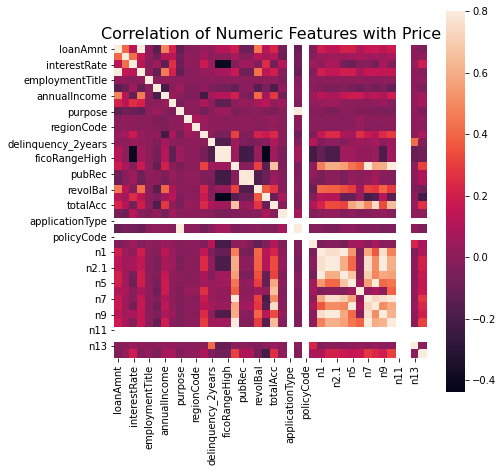

In [154]:
data_numeric = data_train[numerical_fea]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

In [158]:
features = [f for f in data_train.columns if f not in ['id','issueDate','isDefault'] and '_outliers' not in f]
x_train = data_train[features]
#x_test = data_testA[features]
y_train = data_train['isDefault']